In [1]:
import os
from glob import glob
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from darts import TimeSeries
from darts.datasets import AirPassengersDataset
%cd ..
%ls

/home/mahdigilany/offline_codes/codes/ts_snr
configs/     logs/    notebooks/  README.md         scripts/     src/
darts_logs/  main.py  OLD/        requirements.txt  slurm_logs/  wandb/


In [2]:
i_th_run = 0
exp_name = f"test_etth2_deeptime_different_optimizers"
main_dir = f"logs/experiments/runs/{exp_name}"
main_dir = os.path.join(os.getcwd(), main_dir)
work_dir = glob(os.path.join(main_dir, "**/darts_logs"), recursive=True)
config_dir = glob(os.path.join(main_dir, "**/config.yaml"), recursive=True)
config_dir = [dir for dir in config_dir if "wandb" not in dir]
work_dir = work_dir[i_th_run]
config_dir = config_dir[i_th_run]
config_dir

'/home/mahdigilany/offline_codes/codes/ts_snr/logs/experiments/runs/test_etth2_deeptime_different_optimizers/2023-06-12_14-49-07/config.yaml'

In [3]:
from omegaconf import OmegaConf
from src.driver.drivers import inference_darts_lightning_driver_run
from darts.models.forecasting.torch_forecasting_model import TorchForecastingModel

config = OmegaConf.load(config_dir)
config.logger = None
model: TorchForecastingModel
model, data, metrics = inference_darts_lightning_driver_run(config)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Using component OT as target series.


wandb: Currently logged in as: mahdigilany (borealisai). Use `wandb login --relogin` to force relogin


In [4]:
train, val, test, scaler = data.train_series, data.val_series, data.test_series, data.scaler
# model.load_weights_from_checkpoint(config.model.model_name, work_dir=work_dir) # don't use load_from_checkpoint since needs logger and produces error

## manual prediction using manual test loader

### manual load

In [5]:
from darts.models.forecasting.torch_forecasting_model import _get_checkpoint_folder, _get_checkpoint_fname

model_name = config.model.model_name

file_name = _get_checkpoint_fname(work_dir, model_name, best=True)
if file_name[:5] == "last-" or file_name[:5] == "best-":
    checkpoint_dir = _get_checkpoint_folder(work_dir, model_name)
    
ckpt_path = os.path.join(checkpoint_dir, file_name)
ckpt = torch.load(ckpt_path)
ckpt_hyper_params = ckpt["hyper_parameters"]

mock_train_sample = [
    np.zeros(sample_shape) if sample_shape else None
    for sample_shape in ckpt["train_sample_shape"]
]
model.train_sample = tuple(mock_train_sample)
model.model = model._init_model()
model.model.to_dtype(ckpt["model_dtype"])
model.model.load_state_dict(ckpt["state_dict"], strict=True)
model._fit_called = True

### manual prediction

In [35]:
from darts.timeseries import concatenate 
from darts.utils.data.sequential_dataset import PastCovariatesSequentialDataset


horizon = 96
lookback = 672
val_test_series_trimmed = concatenate([val[-lookback:], test])
# test_ds = model._build_train_dataset(val_test_series_trimmed, past_covariates=None, future_covariates=None, max_samples_per_ts=None)
test_ds = PastCovariatesSequentialDataset(val_test_series_trimmed, input_chunk_length=lookback, output_chunk_length=horizon, covariates=None, use_static_covariates=False)
from torch.utils.data import DataLoader
from tqdm import tqdm
test_dl = DataLoader(
    test_ds,
    batch_size=model.batch_size,
    shuffle=False,
    num_workers=0,
    pin_memory=True,
    drop_last=False,
    collate_fn=model._batch_collate_fn,
    )

pl_model = model.model 
pl_model.eval()
preds = []
targets = []
for batch in tqdm(test_dl, desc="evaluating on test set"):
    input_series, _, _, target_series = batch
    input_series = input_series.to(device=pl_model.device, dtype=pl_model.dtype)
    target_series = target_series.to(device=pl_model.device, dtype=pl_model.dtype)
    pred = pl_model((input_series, _))
    preds.append(pred.detach().cpu())
    targets.append(target_series.detach().cpu())
preds = torch.cat(preds, dim=0)
targets = torch.cat(targets, dim=0)

preds = preds.flip(dims=[0])
targets = targets.flip(dims=[0])

evaluating on test set: 100%|██████████| 106/106 [00:06<00:00, 16.66it/s]


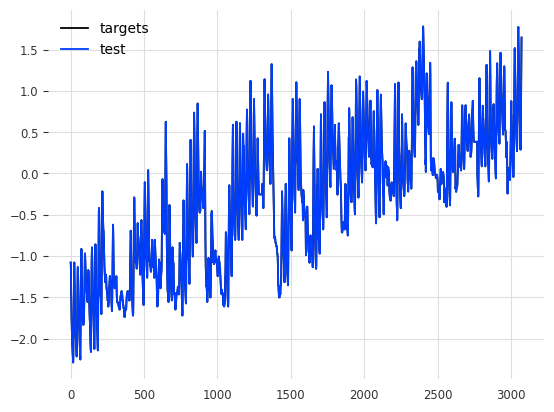

In [37]:
component = 0
n = 96*32
which_th = 95
plt.plot(range(len(targets[:n,which_th,component])), targets[:n,which_th,component], label="targets")
# plt.plot(range(len(preds[:n,which_th,component,0])), preds[:n,which_th,component,0], label="preds")
# plt.plot(range(len(targets[-n:,which_th+1,component])), targets[-n:,which_th+5,component], label="targets")
plt.plot(range(len(test._xa.values[:n,component,0])), test._xa.values[which_th:n+which_th,component,0], label="test")
plt.legend()

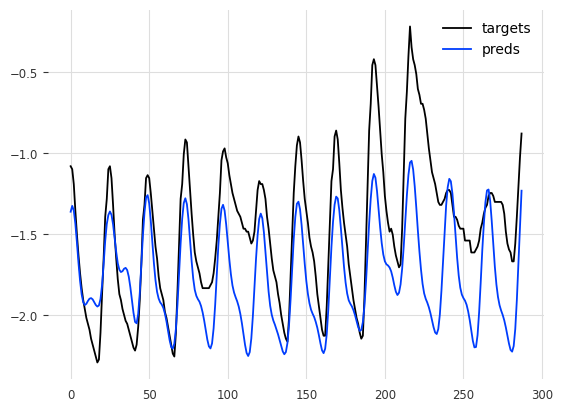

In [42]:
component = 0
n = 96*3
which_th = 95
plt.plot(range(len(targets[:n,which_th,component])), targets[:n,which_th,component], label="targets")
plt.plot(range(len(preds[:n,which_th,component,0])), preds[:n,which_th,component,0], label="preds")
# plt.plot(range(len(targets[-n:,which_th+1,component])), targets[-n:,which_th+5,component], label="targets")
# plt.plot(range(len(test._xa.values[:n,component,0])), test._xa.values[which_th:n+which_th,component,0], label="test")
plt.legend()

## historical forecast instead on manual test loader

In [14]:
from darts.timeseries import concatenate 
train_val_series_trimmed = concatenate([train, val])[-max(len(test), config.model.input_chunk_length):] # TODO: this is not a good way to do it
train_val_test_series_trimmed = concatenate([train_val_series_trimmed[-config.model.input_chunk_length:], test])

In [15]:
train_val_test_series_trimmed.time_index[671], test.time_index[0], test.start_time()

(Timestamp('2018-02-01 14:00:00', freq='H'),
 Timestamp('2018-02-01 15:00:00', freq='H'),
 Timestamp('2018-02-01 15:00:00', freq='H'))

### historical_forecasts on values close to validation

In [ ]:
n = 100
backtest_series = model.historical_forecasts(
    train_val_test_series_trimmed[:config.model.input_chunk_length+config.model.output_chunk_length+n],
    start=test.start_time(),
    forecast_horizon=config.model.output_chunk_length,
    retrain=False,
    verbose=True,
    # stride=stride, #default 1
    last_points_only=False, #default True 
    )

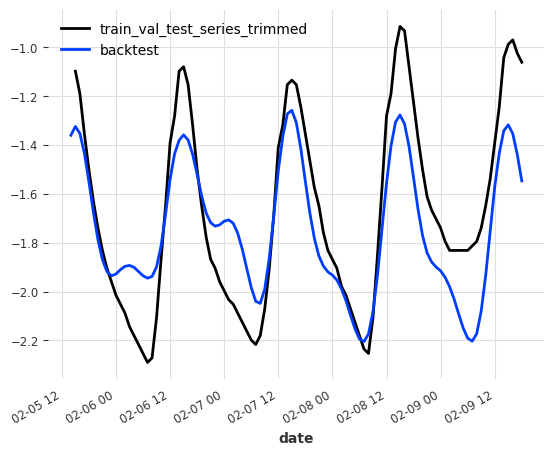

In [33]:
list_lasts_backtest = [backtest[-1] for backtest in backtest_series]
list_lasts_backtest = concatenate(list_lasts_backtest)
train_val_test_series_trimmed[config.model.input_chunk_length+config.model.output_chunk_length:config.model.input_chunk_length+config.model.output_chunk_length+n].plot(label="train_val_test_series_trimmed")
list_lasts_backtest.plot(label="backtest")

### historical_forecasts on values far from validation

In [ ]:
n = 1000
backtest_series = model.historical_forecasts(
    train_val_test_series_trimmed[-(config.model.input_chunk_length+config.model.output_chunk_length+n):],
    start=test[-(config.model.input_chunk_length+config.model.output_chunk_length+n):].start_time(),
    forecast_horizon=config.model.output_chunk_length,
    retrain=False,
    verbose=True,
    # stride=stride, #default 1
    last_points_only=False, #default True 
    )

#### a couple of predicted series in between

2018-05-20 03:00:00 2018-05-20 02:00:00


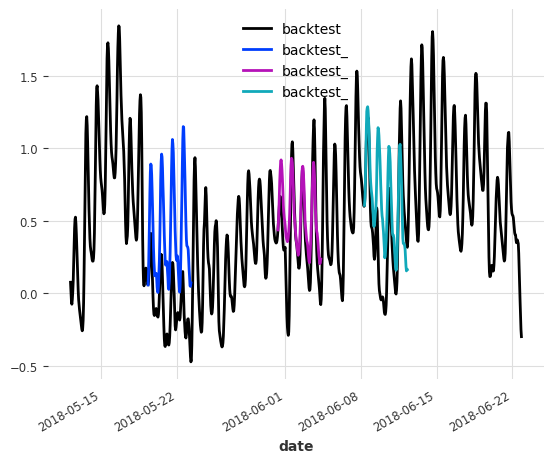

In [75]:
list_lasts_backtest = [backtest[0] for backtest in backtest_series]
list_lasts_backtest = concatenate(list_lasts_backtest)
# train_val_test_series_trimmed[-n:].plot(label="train_val_test_series_trimmed")
list_lasts_backtest.plot(label="backtest")
print(backtest_series[191].time_index[0], train_val_test_series_trimmed[-n-1:].time_index[95])
backtest_series[96*2-20].plot(label="backtest_")
backtest_series[96*5-20].plot(label="backtest_")
backtest_series[96*7-20].plot(label="backtest_")
 

#### only first values of predicted series plotted

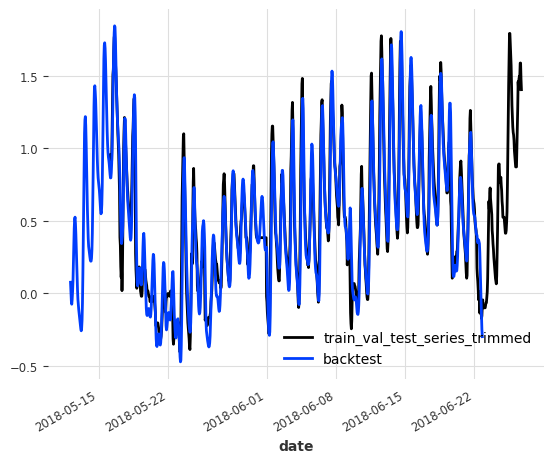

In [112]:
list_lasts_backtest = [backtest[0] for backtest in backtest_series]
list_lasts_backtest = concatenate(list_lasts_backtest)
train_val_test_series_trimmed[-n:].plot(label="train_val_test_series_trimmed")
list_lasts_backtest.plot(label="backtest")


In [113]:
train_val_test_series_trimmed[-96].time_index, list_lasts_backtest.time_index[-1]

(DatetimeIndex(['2018-06-22 20:00:00'], dtype='datetime64[ns]', name='date', freq='H'),
 Timestamp('2018-06-22 20:00:00', freq='H'))

#### last values of predicted series plotted

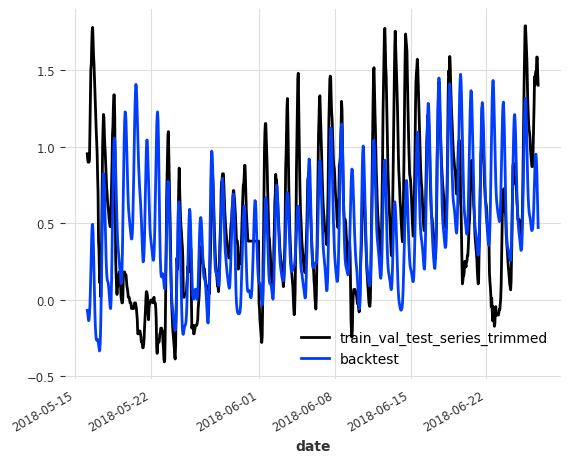

In [114]:
list_lasts_backtest = [backtest[-1] for backtest in backtest_series]
list_lasts_backtest = concatenate(list_lasts_backtest)
train_val_test_series_trimmed[-n:].plot(label="train_val_test_series_trimmed")
list_lasts_backtest.plot(label="backtest")


In [115]:
train_val_test_series_trimmed[-n:].time_index[0], list_lasts_backtest.time_index[0]

(Timestamp('2018-05-16 03:00:00', freq='H'),
 Timestamp('2018-05-16 03:00:00', freq='H'))

### test is our dataloader prediction matches the historical forecasting predictions

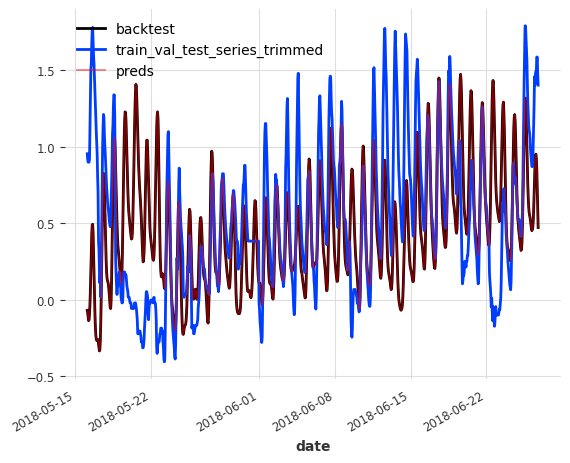

In [129]:
component = 0
n = 1001
which_th = 95
list_lasts_backtest = [backtest[which_th] for backtest in backtest_series]
list_lasts_backtest = concatenate(list_lasts_backtest)
list_lasts_backtest.plot(label="backtest")
train_val_test_series_trimmed[-n:].plot(label="train_val_test_series_trimmed")
plt.plot(list_lasts_backtest.time_index, preds[-n:,which_th,component,0], label="preds", color="red", alpha=0.5)
plt.legend()

### calculate metrics

In [ ]:
from src.utils.metrics import calculate_metrics
results = calculate_metrics(
    [train_val_test_series_trimmed[-n:]]*len(backtest_series),
    backtest_series,
    reduction=np.array,
    verbose=True,
    n_jobs=-1
    )    

In [138]:
np.array(results['mse']).mean(), np.array(results['mae']).mean(), np.array(results['mape']).mean(), np.array(results['smape']).mean(), np.array(results['rmse']).mean(), np.array(results['r2']).mean()

(0.21046891858121383,
 0.33896728912112273,
 503.26643956101253,
 85.7308304101625,
 0.4016309768361865,
 -inf)

### cross correlation FAILED

In [221]:
from darts.utils.statistics import plot_acf, check_seasonality
from statsmodels.tsa.stattools import acf, ccf
series_no = 95
target = train_val_test_series_trimmed[-n:]._xa.values
target_backtest = targets[-n:,:,0]

sum_array = np.zeros(len(target))
for i in range(len(train_val_test_series_trimmed[-n:])-95):
    series_no = 95 + i
    # cross_correlation = ccf(backtest_series[series_no]._xa.values, target, adjusted=False, fft=False)
    cross_correlation = ccf(target_backtest[series_no,:], target, adjusted=False, fft=False)
    cross_correlation = cross_correlation[i:] # remove the first i values
    sum_array[:len(cross_correlation)] += cross_correlation
   
    
    

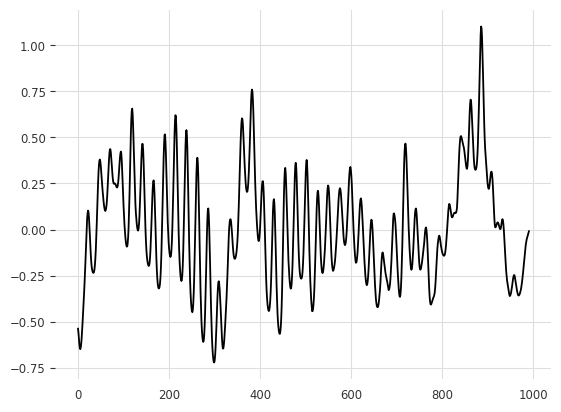

In [224]:
i = 10
series_no = 95 + i
cc = ccf(target_backtest[series_no,:], target, adjusted=False, fft=False)
plt.plot(cc[i:])

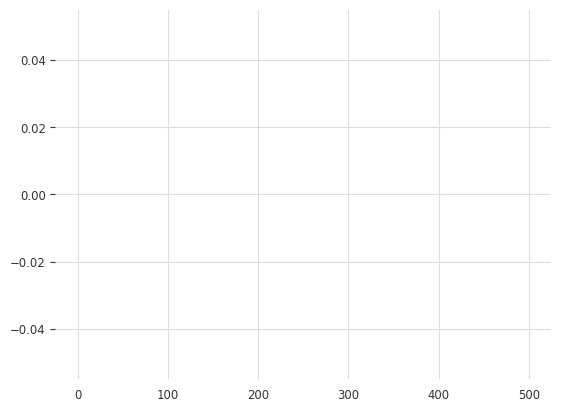

In [219]:
m=96*1
nlags=500
for i in range(len(sum_array)):
    if i>nlags:
        break
    plt.plot(
        (i, i),
        (0, sum_array[i]),
        color=("#b512b8" if m is not None and i == m else "black")
        if True
        else None,
        lw=(1 if m is not None and i == m else 0.5),
    )

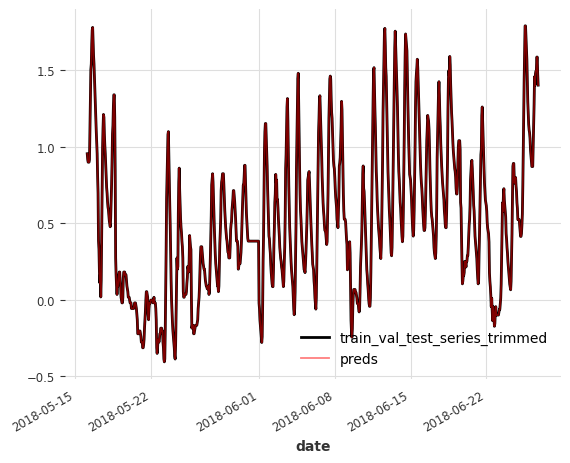

In [194]:
targets[-1001:].shape
component = 0
n = 1001
which_th = 95

train_val_test_series_trimmed[-n:].plot(label="train_val_test_series_trimmed")
plt.plot(train_val_test_series_trimmed[-n:].time_index, targets[-n:,which_th,component], label="preds", color="red", alpha=0.5)
plt.legend()